In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,User Name,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,Location Public Visibility,User Language,Profile Creation Timestamp,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,Num of Profile Likes
0,AL85S14OMDPF01I9,Mf9vfld4Vfe,NaN,Set,Verified,db1a2c,eaf0f2,e70409,False,39600.0,NaN,Enabled,en,Thu Nov 27 05:24:59 +0000 2008,Sydney,95763,4289,30809,873,business,14.792,1.5761,AL85S14OMDPF01I9.png,2815
1,HI11QOPD7BLJTO7Q,xl9gaGN0hxM_,NaN,Set,Verified,0099cc,f6ffd1,fff04d,False,NaN,mumbai,Enabled,en,Fri Jan 15 18:00:46 +0000 2010,NaN,1018746,289,8150,290,unknown,8.183,11.2782,HI11QOPD7BLJTO7Q.png,1242
2,JS49LP5P72RI1OQB,d_uiMm,NaN,Set,Not verified,1fc2de,efefef,1fc2de,False,-18000.0,NYC + 70 Countries Worldwide,Enabled,en,Fri Oct 02 20:15:06 +0000 2009,Central Time (US & Canada),13444,1876,4698,227,unknown,31.823,0.5725,JS49LP5P72RI1OQB.png,1559
3,S0GDSC09MACCLBJP,hfylaRr,https://blob/e/g9pex_vS.com,Not set,Verified,050000,616161,00090a,False,-14400.0,"Indianapolis, In",Enabled,en,Thu Feb 19 14:37:22 +0000 2009,Eastern Time (US & Canada),339168,1148,53216,4035,business,23.052,4.0265,S0GDSC09MACCLBJP.png,6342
4,CRSEMK4QER6LDJSA,hRR1sDGlz5,https://blob/v/Szeo.h4/.com,Set,Not verified,58424d,f7f7f7,000000,False,-18000.0,"777 Beach Blvd. Biloxi, MS",Enabled,en,Tue Mar 31 13:27:52 +0000 2009,Central Time (US & Canada),9215,93,3271,130,unknown,8.418,3.9229,CRSEMK4QER6LDJSA.png,1078


# Modify features

In [3]:
# transform utc offset:
df['Sin_UTC'] = np.sin((11 * 3600 + df['UTC Offset']) / (24 * 3600) * 2 * np.pi)
df['Cos_UTC'] = np.cos((11 * 3600 + df['UTC Offset']) / (24 * 3600) * 2 * np.pi)

# time since creation in days
duration = (pd.to_datetime('today') - 
            pd.to_datetime(df['Profile Creation Timestamp']).dt.tz_localize(None))
df['Duration'] = duration.apply(lambda x: x.days)

# to plot on a log scale
df['Num of Profile Likes+'] = df['Num of Profile Likes']
df.loc[df['Num of Profile Likes+'] == 0, 'Num of Profile Likes+'] = 1

# merge categories names with and without cap letter
df['Location Public Visibility'] = df['Location Public Visibility'].apply(lambda x: x.lower())

# convert personal url into True/False (NaNs or unique)
df['Has Personal URL'] = df['Personal URL'].notna()

## Comments about some features

The following variables should not be included in the regressions:

* Id, User Name, Profile Image: unique for each users
* Personal URL: replaced by Has Personal URL (True/False)
* UTC Offset: replaced by sin_UTC and cos_UTC
* Profile Creation Timestamp: replaced by Duration
* Num of Profiles Likes+: was created just for the plots (but Num of Profiles Likes should be adjusted if taken in logs)

Some missing values of UTC Offset could be obtained from Location (see below).

In [4]:
pd.crosstab(df['UTC Offset'].notna(), df['Location'].notna(), margins=True)

Location,False,True,All
UTC Offset,,,
False,204,282,486
True,1257,5757,7014
All,1461,6039,7500


# Exploring the data

* Numerical features
* Categorical features with few categories
* Categorical features with lots of categories

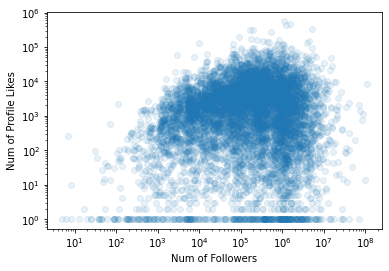

percentage of observations in plot: 100%


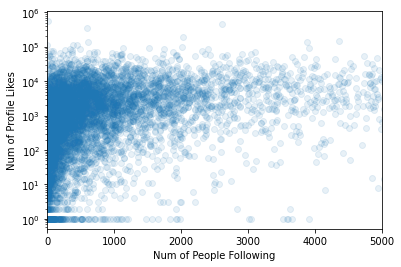

percentage of observations in plot: 89.3%


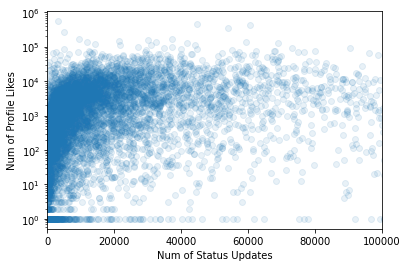

percentage of observations in plot: 93.0%


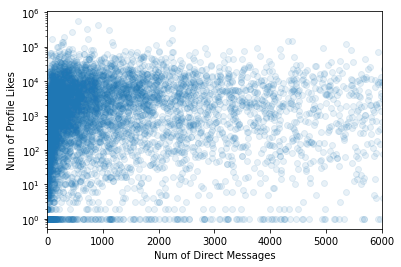

percentage of observations in plot: 89.8%


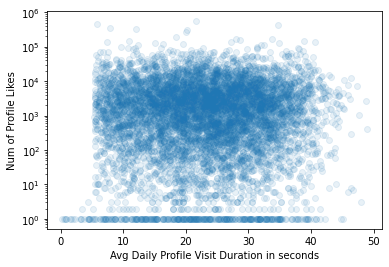

percentage of observations in plot: 100%


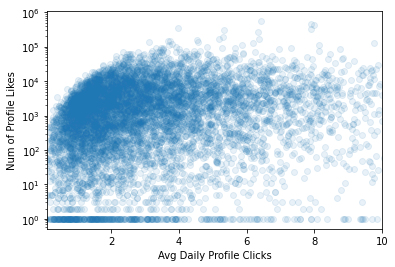

percentage of observations in plot: 97.4%


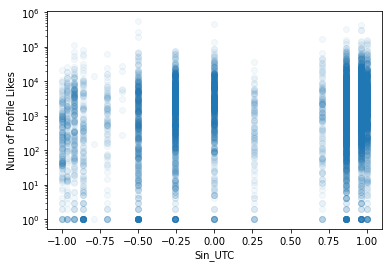

percentage of observations in plot: 100%


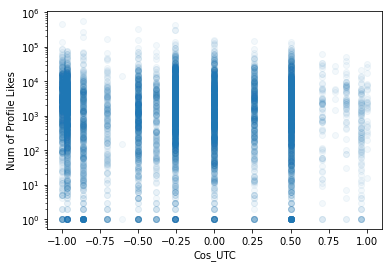

percentage of observations in plot: 100%


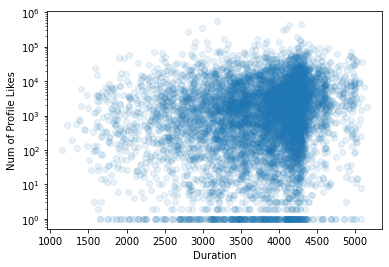

percentage of observations in plot: 100%


In [6]:
# numerical features

def plot(feature, alpha=0.1, xlim=None, xscale=None):
    plt.scatter(df[feature], df['Num of Profile Likes+'], alpha=alpha)
    plt.yscale('log')
    plt.xlabel(feature)
    plt.ylabel('Num of Profile Likes')
    if xlim is not None:
        plt.xlim(xlim)
    if xscale is not None:
        plt.xscale(xscale)
    plt.show()
    if xlim is not None:
        perc_obs = df[feature].between(xlim[0], xlim[1]).sum() / df[feature].notna().sum()
    else:
        perc_obs = 1
    print(f'percentage of observations in plot: {np.round(100*perc_obs, 1)}%')
    
    
plot('Num of Followers', xlim=None, xscale='log')
plot('Num of People Following', xlim=[0, 5e3])
plot('Num of Status Updates', xlim=[0, 1e5])
plot('Num of Direct Messages', xlim=[0, 6e3])
plot('Avg Daily Profile Visit Duration in seconds')
plot('Avg Daily Profile Clicks', xlim=[0.1, 10])
plot('Sin_UTC', alpha=0.05)
plot('Cos_UTC', alpha=0.05)
plot('Duration')


HAS PERSONAL URL:


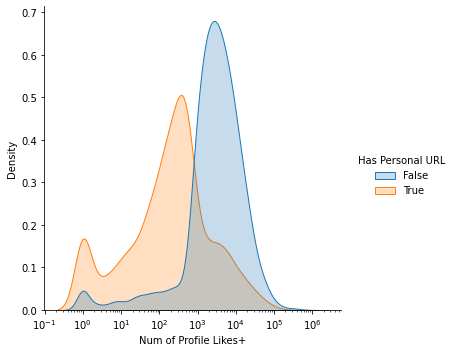

,count,mean,std,min,25%,50%,75%,max
Has Personal URL,,,,,,,,
False,4244.0,7771.720547,18690.397483,1.0,1338.0,3138.0,7726.5,453991.0
True,3256.0,2278.009521,12406.566558,1.0,43.0,235.0,640.0,550594.0



PROFILE COVER IMAGE STATUS:


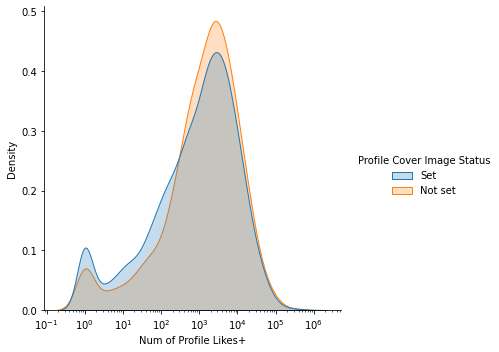

,count,mean,std,min,25%,50%,75%,max
Profile Cover Image Status,,,,,,,,
Not set,1691.0,5683.667652,15791.661495,1.0,392.0,1721.0,5456.00,430248.0
Set,5719.0,5311.902256,16759.963304,1.0,172.0,1273.0,4678.00,550594.0
NaN,90.0,4561.444444,11108.802438,1.0,182.5,1038.0,4325.25,91131.0



PROFILE VERIFICATION STATUS:


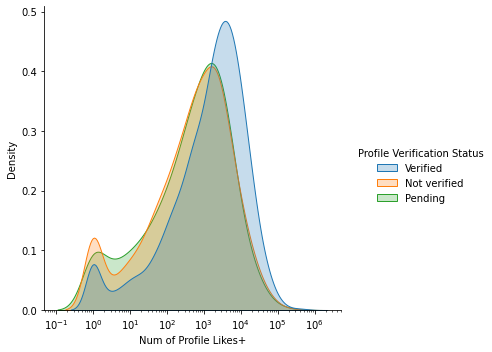

,count,mean,std,min,25%,50%,75%,max
Profile Verification Status,,,,,,,,
Not verified,2146.0,3400.063840,11777.737635,1.0,91.25,647.0,2583.5,340032.0
Pending,583.0,2910.687822,9356.385793,1.0,90.00,692.0,2484.5,173437.0
Verified,4771.0,6582.878432,18719.342028,1.0,355.00,1991.0,6341.5,550594.0



IS PROFILE VIEW SIZE CUSTOMIZED?:


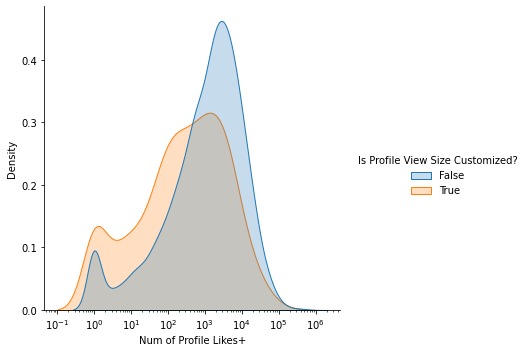

,count,mean,std,min,25%,50%,75%,max
Is Profile View Size Customized?,,,,,,,,
False,6785.0,5649.573618,17022.817297,1.0,255.0,1525.0,5167.0,550594.0
True,715.0,2892.341259,9764.554257,1.0,38.0,331.0,2065.0,173437.0



LOCATION PUBLIC VISIBILITY:


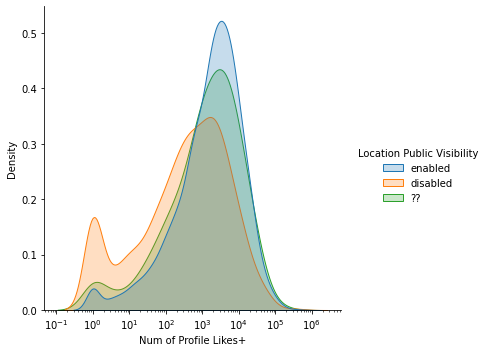

,count,mean,std,min,25%,50%,75%,max
Location Public Visibility,,,,,,,,
??,372.0,5530.354839,12446.935460,1.0,314.75,1628.0,5653.25,173437.0
disabled,2773.0,3699.397043,16778.839275,1.0,52.00,464.0,2453.00,453991.0
enabled,4355.0,6448.831458,16519.255269,1.0,513.00,2160.0,6318.50,550594.0



PROFILE CATEGORY:


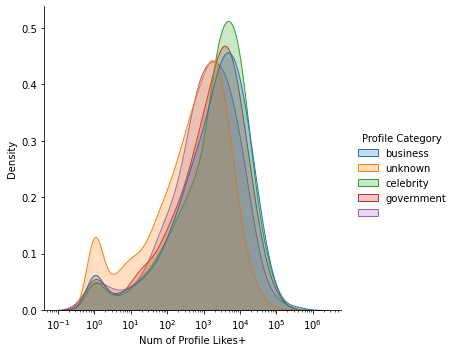

,count,mean,std,min,25%,50%,75%,max
Profile Category,,,,,,,,
,240.0,4587.325000,11092.978948,1.0,343.0,1323.5,4402.75,110907.0
business,1839.0,8605.194671,24117.900116,1.0,448.5,2427.0,8334.50,453991.0
celebrity,1401.0,7406.321199,13917.303932,1.0,531.0,2823.0,8044.00,195625.0
government,660.0,6082.430303,12182.677377,1.0,366.5,2065.5,6169.25,124778.0
unknown,3360.0,2703.514881,12465.013709,1.0,93.0,643.0,2416.25,550594.0


In [7]:
# small number of categories

def show_categories(feature):
    print(f'\n{feature.upper()}:')
    sns.displot(df, x='Num of Profile Likes+', hue=feature, 
            kind='kde', common_norm=False, log_scale=True, fill=True)
    plt.show()
    display(df.groupby(df[feature], dropna=False)['Num of Profile Likes+'].describe())
    
for feature in ['Has Personal URL', 'Profile Cover Image Status',
                'Profile Verification Status', 
                'Is Profile View Size Customized?', 
                'Location Public Visibility', 'Profile Category']:
    show_categories(feature)

In [ ]:
# lots of categories: need to aggregate

def agg_categories(feature, min_size=100):
    val_counts = df[feature].fillna('nan').value_counts()
    l_others = val_counts[val_counts < min_size].index.unique().tolist()
    df[f'Cat {feature}'] = df[feature].fillna('nan').replace(to_replace=l_others,
                                               value='others')
   
for feature in ['Profile Text Color', 'Profile Page Color',
                'Profile Theme Color', 'User Language', 'Location',
                'User Time Zone']:
    agg_categories(feature)
    show_categories(f'Cat {feature}')